# Assumptions:   Predicting Weight Loss and Activity Level (steps)
1. Exploration of the data shows that acitivity level (based on steps and activity colories) is significantly higher on weekends.   Therefore we decided to aggregate by week.   There are 33 weeks.
2. Based on adjusted BMR calculations, we believe this is a 25 year old male, 220 lbs, who has just started a workout program in April of 2018.    ** Need to support why we think this subject is a male, why we think he is 25 years old, and how we calculated an initial weight of 220 lbs**
3. need to document formulas used
4. not enough data to sufficently determine seasonality (partial year)
5. split based on calendar,  starting the second week of October,  which gives us 24 weeks in our train dataset, and 10 weeks in our test dataset
6. Baseline BMR are those days when Minutes_active = 0
7. Can calulate starting weight with approx 95% accuracy.  Can also calculate approximate height based on stride length.
8. Very confident in inital weight, as well as weight in first week of July.  Calculate average calorie intake based first week of November.
9. Have to assume that eating habits don't significantly change from April through December because we don't hace enough data.  We are ignoring Body Fat % because we don't have enough data and it is not necessary to predict weight or activity level (steps).  Have to assume an age (25).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import Holt
from fbprophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

Data Acquire - method.  8 total csvs were combined into a single csv by cut-n-paste.   Each "Activities" section , including Calories Burned, Steps, Distance, Floors, Minutes Sedentary, Minutes Lightly Active, Minutes Fairly Active, Minutes Very Active, and Activity Calories were appended (one after the other). "Calories In" was appended as a final column also using cut-n-paste. The Food Log Daily Totals were ignored (not enough non-zero values to add significant information to the study).   The merged csv file is called Total_Fitbit_2.csv      

In [2]:
df = pd.read_csv('Total_Fitbit_2.csv')

In [3]:
df.shape

(225, 11)

In [4]:
df['Date'] = pd.to_datetime(df.Date)

In [5]:
df.set_index('Date', drop=True, inplace= True)

In [6]:
df.replace(',','', regex=True, inplace=True)

In [7]:
cols = ['Calories_Burned', 'Steps', 'Distance', 'Floors', 'Minutes_Sedentary',
       'Minutes_Lightly_Active', 'Minutes_Fairly_Active',
       'Minutes_Very_Active', 'Activity_Calories', 'Calories_In']

df = df[cols].astype(float)

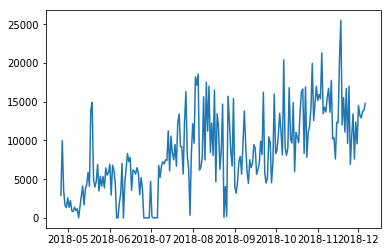

In [8]:
plt.plot(df.Steps)

In [9]:
df.shape

(225, 10)

In [10]:
aggregation = 'mean'
train = df[:'2018-10-07'].Steps.resample('D').agg(aggregation)
test = df['2018-10-07':].Steps.resample('D').agg(aggregation)
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 226
Training Observations: 165
Testing Observations: 61


In [11]:
df['Distance_inches'] = df.Distance*63360

In [12]:
df['Gait_length'] = df.Distance_inches/df.Steps

In [13]:
# height = ((df.Gait_length.mean())/0.43)*2.54
# (the 0.43 comes from -> https://www.scientificamerican.com/article/bring-science-home-estimating-height-walk/)
h = 177.069
a = 25
b = 2145

In [14]:
h

177.069

In [15]:
df['weight_male_lb'] = (((((6.25*h)-(5*a)+5)-b)/-10)*2.20462)

In [16]:
df['weight_male_kg'] = (((6.25*h)-(5*a)+5)-b)/-10

In [17]:
df['weight_female_lb'] = ((((6.25*h)-(5*a)-161)-b)/-10)*2.20462

In [18]:
df['weight_female_kg'] = (((6.25*h)-(5*a)-161)-b)/-10

In [19]:
df['Gait_length'].fillna(df['Gait_length'].mean(), inplace=True)

In [20]:
df.head()

,Calories_Burned,Steps,Distance,Floors,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Activity_Calories,Calories_In,Distance_inches,Gait_length,weight_male_lb,weight_male_kg,weight_female_lb,weight_female_kg
Date,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,0.0,87436.8,29.831730,255.365268,115.831875,291.96196,132.431875
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,0.0,297792.0,29.865811,255.365268,115.831875,291.96196,132.431875
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0,0.0,105177.6,29.871514,255.365268,115.831875,291.96196,132.431875
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0,0.0,48787.2,29.766443,255.365268,115.831875,291.96196,132.431875
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0,0.0,39283.2,29.692517,255.365268,115.831875,291.96196,132.431875


In [21]:
df.Calories_In.replace(to_replace=(0.0), value='1850', regex=True, inplace=True)

In [22]:
df.tail(20)

,Calories_Burned,Steps,Distance,Floors,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Activity_Calories,Calories_In,Distance_inches,Gait_length,weight_male_lb,weight_male_kg,weight_female_lb,weight_female_kg
Date,,,,,,,,,,,,,,,,
2018-11-17,4548.0,20395.0,10.06,31.0,464.0,347.0,54.0,90.0,3077.0,1850,637401.6,31.252836,255.365268,115.831875,291.96196,132.431875
2018-11-18,4832.0,25512.0,12.00,23.0,450.0,269.0,53.0,154.0,3373.0,1850,760320.0,29.802446,255.365268,115.831875,291.96196,132.431875
2018-11-19,3697.0,11993.0,5.56,17.0,502.0,255.0,34.0,43.0,2062.0,1850,352281.6,29.373935,255.365268,115.831875,291.96196,132.431875
2018-11-20,3966.0,15527.0,7.27,13.0,810.0,196.0,11.0,96.0,2260.0,1850,460627.2,29.666207,255.365268,115.831875,291.96196,132.431875
2018-11-21,3738.0,11079.0,5.16,4.0,582.0,328.0,9.0,33.0,2101.0,1850,326937.6,29.509667,255.365268,115.831875,291.96196,132.431875
2018-11-22,4494.0,16705.0,7.84,177.0,522.0,284.0,18.0,115.0,2868.0,1850,496742.4,29.736151,255.365268,115.831875,291.96196,132.431875
2018-11-23,3325.0,9602.0,4.53,16.0,660.0,269.0,23.0,12.0,1619.0,1850,287020.8,29.891773,255.365268,115.831875,291.96196,132.431875
2018-11-24,4098.0,17004.0,9.20,23.0,532.0,217.0,13.0,100.0,2428.0,1850,582912.0,34.280875,255.365268,115.831875,291.96196,132.431875
2018-11-25,3005.0,6921.0,3.26,11.0,614.0,281.0,3.0,6.0,1306.0,1850,206553.6,29.844473,255.365268,115.831875,291.96196,132.431875


In [23]:
df['Calories_In']=df['Calories_In'].astype(float)

In [24]:
df['Weight_loss'] = (df.Calories_In - df.Calories_Burned)/3500

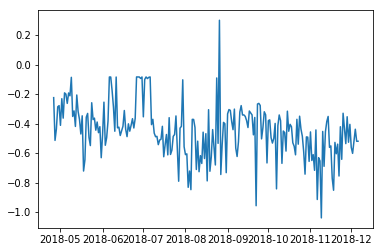

In [25]:
plt.plot(df.Weight_loss)

In [26]:
# df2 = df[df['Calories_In'] > 0]

In [27]:
# df3 = df[df['Minutes_Lightly_Active'] == 0]

# Garys models below this line
- build 2 prediction models a) Holt Linear   b) Prophet
- Each model to run on two "y" variables    1) Weight (engineered feature)     2) Step Activity

First,   build Holt Linear prediction for Steps
pull out any rows with nulls before analyizing

In [36]:
df.describe()

,Calories_Burned,Steps,Distance,Floors,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Activity_Calories,Calories_In,Distance_inches,Gait_length,weight_male_lb,weight_male_kg,weight_female_lb,weight_female_kg,Weight_loss
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,2.250000e+02,2.250000e+02,2.250000e+02,2.250000e+02,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667,1840.351111,256405.248000,29.976234,2.553653e+02,1.158319e+02,2.919620e+02,1.324319e+02,-0.446160
std,632.426578,5255.746608,2.506253,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790,125.757158,158796.188816,0.556180,1.338799e-12,1.424254e-13,1.025463e-12,6.266718e-13,0.186219
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,600.000000,0.000000,27.952941,2.553653e+02,1.158319e+02,2.919620e+02,1.324319e+02,-1.039429
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000,1850.000000,140659.200000,29.863124,2.553653e+02,1.158319e+02,2.919620e+02,1.324319e+02,-0.549143
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000,1850.000000,233164.800000,29.884950,2.553653e+02,1.158319e+02,2.919620e+02,1.324319e+02,-0.438571
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000,1850.000000,373824.000000,29.921389,2.553653e+02,1.158319e+02,2.919620e+02,1.324319e+02,-0.348286
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000,2276.000000,760320.000000,34.280875,2.553653e+02,1.158319e+02,2.919620e+02,1.324319e+02,0.300286


In [29]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse 

In [30]:
def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()   

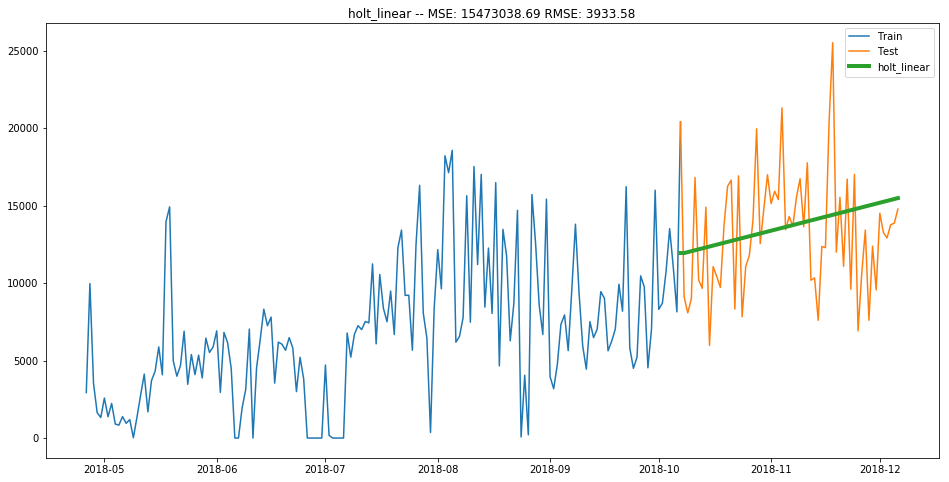

In [31]:
y_hat = pd.DataFrame(dict(actual=test))
holt = Holt(train).fit(smoothing_level = .18, smoothing_slope = .01)
y_hat['holt_linear'] = holt.forecast(test.shape[0])
y_hat.holt_linear.fillna(method='bfill', inplace=True)
plot_and_eval(y_hat.holt_linear)

Now extend array to end of December,  predict it, and output to csv

In [32]:
for dayn in range(7,32):
    y_hat = y_hat.append(pd.DataFrame(index=[pd.datetime(2018,12,dayn)]), sort=True)
y_hat['holt_linear'] = holt.predict(start=min(y_hat.index), end=pd.datetime(2018,12,31))
y_hat = y_hat.fillna(0)
y_hat.to_csv('Steps_predict.csv')

Second, build Holt Linear prediction for Weight Loss

In [37]:
aggregation = 'mean'
train = df[:'2018-10-07'].Weight_loss.resample('D').agg(aggregation)
test = df['2018-10-07':].Weight_loss.resample('D').agg(aggregation)

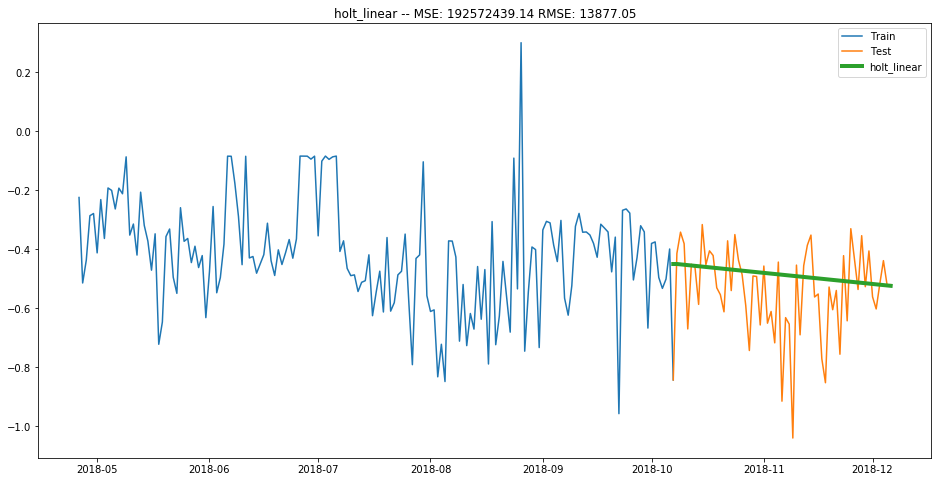

In [68]:
y_hat = pd.DataFrame(dict(actual=test))
holt = Holt(train).fit(smoothing_level = .012, smoothing_slope = .004)
y_hat['holt_linear'] = holt.forecast(test.shape[0])
y_hat.holt_linear.fillna(method='bfill', inplace=True)
plot_and_eval(y_hat.holt_linear)

Now extend array to end of December,  predict it, and output to csv

In [69]:
for dayn in range(7,32):
    y_hat = y_hat.append(pd.DataFrame(index=[pd.datetime(2018,12,dayn)]), sort=True)
y_hat['holt_linear'] = holt.predict(start=min(y_hat.index), end=pd.datetime(2018,12,31))
y_hat = y_hat.fillna(0)
y_hat.to_csv('Weight_predict.csv')